In [1]:
from data_common.notebook import *
from data_common.charting.chart import vconcat, hconcat

reset_renderer()

# UK Composite Rural Urban Classification

A composite 2- and 3-fold metric to describe various small areas (LSOAs/Datazones/SOAs) on a rural/urbal scale that is comparable across the UK. 

This can be found in `output/composite_ruc.csv`.

## Background

For small areas (LSOA/Datazones/SOA) there are different measures of if an area how rural/urban an area is depending on the UK nation. 

* England/Wales - [ONS Rural/Urban Classification (RUC)](https://www.ons.gov.uk/methodology/geography/geographicalproducts/ruralurbanclassifications) [(data)](https://geoportal.statistics.gov.uk/datasets/276d973d30134c339eaecfc3c49770b3_0)
* Scotland - [Scottish Government Urban Rural (SGUR) Classification](https://www.gov.scot/publications/scottish-government-urban-rural-classification-2016/pages/2/)
* Northern Ireland -  NISRA [Delineation of settlements (SDL)](https://www.nisra.gov.uk/publications/urban-rural-geography-documents-2015)

As these reflect different needs in different nations  (for instance, Scotland is far more concerned with remoteness), these scales are not directly comparable. 

England/Wales have an 11 point scale, Scotland has a varying 2,3,6 and 8 scale, and Northern Ireland has 8 bands for settlement size with a 3 point urban/rural scale (this is a Urban/Rural/Mixed as opposed to Scotland's 3-point scale, which splits rural areas by remoteness).

While all split in some form into rural/urban areas, these are based on different definitions. For England/Wales a rural area is part of a settlement of less than 10,000 people, while for Northern Ireland this is less than 5,000 people and Scotland it is less than 3,000 people. 

## Building a comparable measure

All metrics can roughly converge on a binary urban/rural scale where an urban areas are over 10,000 people. For Scotland, using the 6-fold scale, 1-2 are urban, 3-6 are rural. For Northern Ireland, Bands A-D are urban and E-H are rural. 

This is a measure of density that makes most sense in England. A measure roughly equivilent to the Scottish definition (where 5-6 on six point scale are rural) can be found by counting NI G-H bands as rural (max size 2,500), and the RUC E groupings (Villages and Hamlets) as rural. This last one is not directly comparable as different rural classifications in RUC are not based directly on population cut-offs, but is the easiest fix.

This leads to a 2-fold and 3-fold scale:

* CRUC-2: 0-Urban/1-Rural
* CRUC-3: 0-Urban/1-Rural/2-More Rural

Where Urban always means more than 10,000 and 'More Rural' should generally track different ideas of a 'village' sized settlement. 


## National distribution of urban and rural areas

The following tables the breakdown of population between the different urban/rural categories (2019 population).

LSOA are based on roughly even population, so the distribution of LSOA better reflects distribution of population rather than area. However, DZ and SOAs have lower numbers of people on average, as such you need to bring back in better counts of population to properly understand national breakdowns (within each country the count of LSOA/DZ/SOA will work fine).

### Two-fold divide (population)

In [13]:
df = pd.read_csv(Path("output", "composite_ruc.csv"))

formats = {x: "{:,.0%}" for x in ["E","N", "S", "W"]}

def pivot(index, measure):
    pt = df.pivot_table(measure, index, "nation", aggfunc="sum")
    pt = pt.apply(lambda x: (x / float(x.sum()))).round(2)
    pt = pt.reset_index()  # bring back column name
    pt[index] = pt[index].map({0: "Urban", 1: "Rural", 2: "More Rural"})
    pt = pt.set_index(index)
    pt.columns.name = None
    pt = pt.reset_index()
    display(pt.style.format(formats).hide(axis="index"))  # type: ignore

pivot("ukruc-2", "pop")


ukruc-2,E,N,S,W
Urban,83%,55%,71%,69%
Rural,17%,45%,29%,31%


### Two-fold divide (area)

In [14]:
pivot("ukruc-2", "area")

ukruc-2,E,N,S,W
Urban,19%,5%,4%,11%
Rural,81%,95%,96%,89%


### Three-fold divide (population)


In [15]:
pivot("ukruc-3", "pop")

ukruc-3,E,N,S,W
Urban,83%,55%,71%,69%
Rural,9%,13%,12%,17%
More Rural,8%,32%,17%,14%


### Three-fold divide (area)



In [16]:
pivot("ukruc-3", "area")

ukruc-3,E,N,S,W
Urban,19%,5%,4%,11%
Rural,15%,7%,2%,11%
More Rural,66%,88%,94%,78%


## Population density index

As most of the population in all areas is 'Urban', more subtle trends may missed using this index. 

The output file also includes a population density index, which sorts lsoa/dz/soa by population density and assigns deciles and quintiles based on area and population (population is more useful for people based data).

This was generated using the shapefiles for LSOA/DZ/SOA (using the high water mark shapefile for England and Wales) and the mid-year population estimates from the various statistics authorities for 2019.

The following tables and shows the differing distributions of population and area for deciles calculated over the whole of the UK. 

### Population based distribution



Overall density decile (pop),E,N,S,W
1,11%,1%,6%,2%
2,11%,4%,9%,4%
3,10%,5%,11%,5%
4,10%,6%,13%,7%
5,10%,7%,13%,8%
6,10%,9%,13%,9%
7,10%,11%,12%,11%
8,10%,12%,6%,16%
9,10%,16%,4%,20%
10,9%,30%,13%,17%


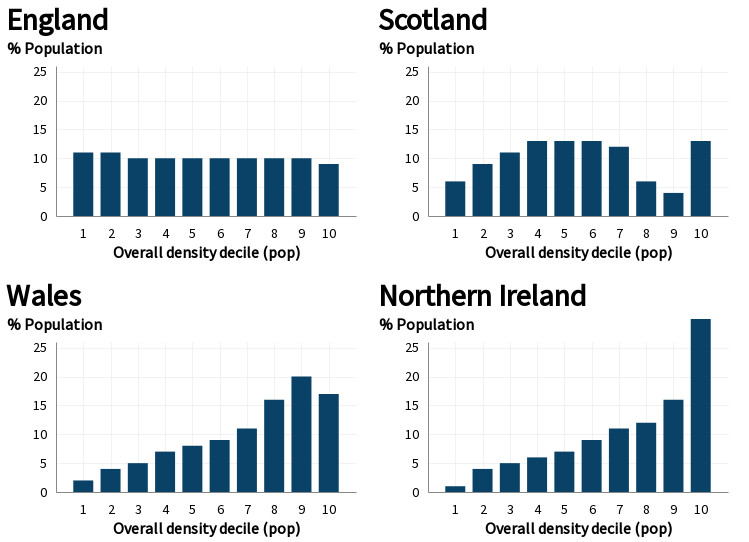

In [17]:
def pivot_density(measure, get_df=False):
    pt = df.pivot_table(
        measure, columns="nation", index=[f"density_{measure}_decile"], aggfunc="sum"
    )
    pt = pt.fillna(0)
    index_name = f"Overall density decile ({measure})"
    pt.index.name = index_name
    pt = pt.reset_index()
    pt.columns.name = None
    for n in "ENSW":
        pt[n] = round(pt[n] / pt[n].sum(), 2)
    if get_df:
        return pt
    pt = pt.set_index(index_name)
    pt = pt.reset_index()
    display(pt.style.format(formats).hide(axis="index"))  # type: ignore


from altair.expr import datum


def density_chart(measure):

    if measure == "pop":
        nice_measure = "Population"
    else:
        nice_measure = "Area"

    pt = pivot_density(measure, get_df=True)
    assert pt is not None
    melt = pt.melt(f"Overall density decile ({measure})", var_name="distribution")

    melt["distribution"] = melt.distribution.map(
        {"E": "England", "S": "Scotland", "W": "Wales", "N": "Northern Ireland"}
    )

    melt["value"] *= 100
    melt.head()
    colors = altair_theme.mysoc_palette_colors

    base = (
        alt.Chart(melt)
        .mark_bar(size=20)
        .encode(  # type: ignore
            x=alt.X(f"Overall density decile ({measure})", scale=alt.Scale(bins=list(range(1, 11)))),  # type: ignore
            y=alt.Y(
                "value", title=f"% {nice_measure}", scale=alt.Scale(domain=(0, 25))
            ),
        )
        .properties(width=300, height=150)
    )  # type: ignore

    chart = alt.vconcat()
    row = alt.hconcat()
    for n in ["England", "Scotland"]:
        row |= base.transform_filter(datum.distribution == n).properties(title=n)
    chart &= row
    row = alt.hconcat()
    for n in ["Wales", "Northern Ireland"]:
        row |= base.transform_filter(datum.distribution == n).properties(title=n)
    chart &= row
    display(chart)


reset_renderer()

pivot_density("pop")
density_chart("pop")

## Area based distribution

,E,N,S,W
Overall density decile (area),,,,
1,16%,6%,2%,8%
2,16%,8%,1%,9%
3,15%,13%,1%,8%
4,14%,17%,2%,7%
5,14%,19%,2%,9%
6,11%,22%,5%,14%
7,8%,14%,11%,18%
8,5%,1%,15%,26%
9,2%,0%,28%,1%


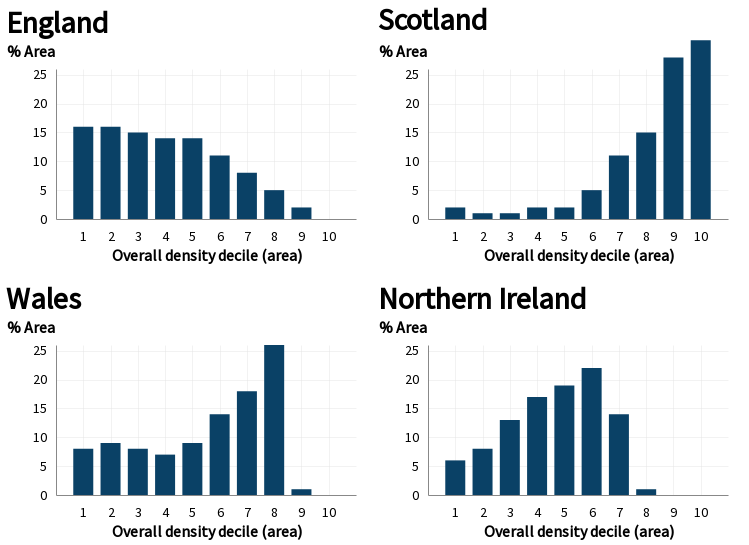

In [12]:
reset_renderer()
pivot_density("area")
density_chart("area")

## Rebuilding

Run `dataset build`.

The scale is built in two steps. As the Northern Ireland lookup only provides SOA to rural/urban/mixed, a settlement band per Super Output Areas needs to be recomposited from Small Areas.

This is done by converting the settlement band to a number from 1-8 (where 8 is the most rural), taking an average of the SA bands, and rounding to the nearest whole number, and then reconverting into a Band for the SOA. 

The three different sets of statistics are then combined using the described steps to create the composite scales.


## Licencing

Source indexes for each country are licenced as Open Government License (OGL) version 3.0.

Unless otherwise stated, composite datasets are licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

Code and scripts are licenced under a MIT Licence. 

## Citation

Future versions may use same URL, but past versions will be included in git history.

Suggested citation if using the dataset:

```
Parsons, Alex (2021), UK Rural/Urban measures, https://github.com/mysociety/uk_ruc
```

## Source files

* England/Wales - [ONS Rural/Urban Classification (RUC)](https://www.ons.gov.uk/methodology/geography/geographicalproducts/ruralurbanclassifications) [(data)](https://geoportal.statistics.gov.uk/datasets/276d973d30134c339eaecfc3c49770b3_0)
* Scotland - [Scottish Government Urban Rural (SGUR) Classification](https://www.gov.scot/publications/scottish-government-urban-rural-classification-2016/pages/2/)
* Northern Ireland -  NISRA [Delineation of settlements (SDL)](https://www.nisra.gov.uk/publications/urban-rural-geography-documents-2015)
* [ONS 2019 population estimates](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates)
* [National Records Scotland 2019 Population Estimates](https://www.nrscotland.gov.uk/statistics-and-data/statistics/statistics-by-theme/population/population-estimates)
* [NISRA 2019 2019 population estimates](https://www.nisra.gov.uk/publications/2019-mid-year-population-estimates-northern-ireland)
* [SOA shapefile](https://www.nisra.gov.uk/support/geography/northern-ireland-super-output-areas)
* [Datazone shapefile](https://data.gov.uk/dataset/ab9f1f20-3b7f-4efa-9bd2-239acf63b540/data-zone-boundaries-2011)
* [LSOA shapefiles](https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-generalised-clipped-bgc-ew-v3?geometry=-28.309%2C50.522%2C23.964%2C55.161)
